# 05_mini-AlexNet-train

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import tqdm
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import matplotlib.pyplot as plt
from  matplotlib.colors import TwoSlopeNorm
import torch.nn.functional as F
from scipy.stats import bernoulli
import seaborn as sns

In [4]:
from src.training_testing_loop import full_train, format_training_outputs, train_loop, test_loop

# Data

In [5]:
from src.load_CIFAR10 import get_train_valid_loader, get_test_loader

In [6]:
train_loader, valid_loader = get_train_valid_loader(
    data_dir='./data/', batch_size=128, random_seed=1, 
    augment=False, download=True, subsample_frac=0.10
)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
test_loader = get_test_loader(data_dir='./data', batch_size=128)

Files already downloaded and verified


# Train random

In [8]:
from src.CNN_pruning import RandomPruneNet

In [10]:
num_classes = 10 # output number of classes
num_epochs = 20  # number of total training loops?
# batch_size = 128  # how much data to train on at a time
learning_rate = 0.005 # SGD step size. Scheduler with 0.1 for 0-100, 0.01 for 100-200, and 0.001 for 200 to 250

random_model = RandomPruneNet(num_training_iter=num_epochs, num_classes=num_classes, verbose=False).to(device)

random_train_losses_epoch, random_val_losses_epoch, random_test_df = full_train(
    random_model,
    train_loader, valid_loader, test_loader,
    learning_rate = 0.005,
    loss_fn = nn.CrossEntropyLoss(),
    model_update_params=True,
    plot=False,
    verbose=False,
)

Epochs:   0%|                                                                                                                          | 0/20 [00:00<?, ?it/s]

0 tensor(4.2155, grad_fn=<NllLossBackward0>)


Epochs:   0%|                                                                                                                          | 0/20 [00:00<?, ?it/s]


TypeError: CrossEntropyLoss.forward() takes 3 positional arguments but 130 were given

In [328]:
random_stack_training_losses_df, random_stack_val_losses_df = format_training_outputs(random_train_losses_epoch, random_val_losses_epoch)

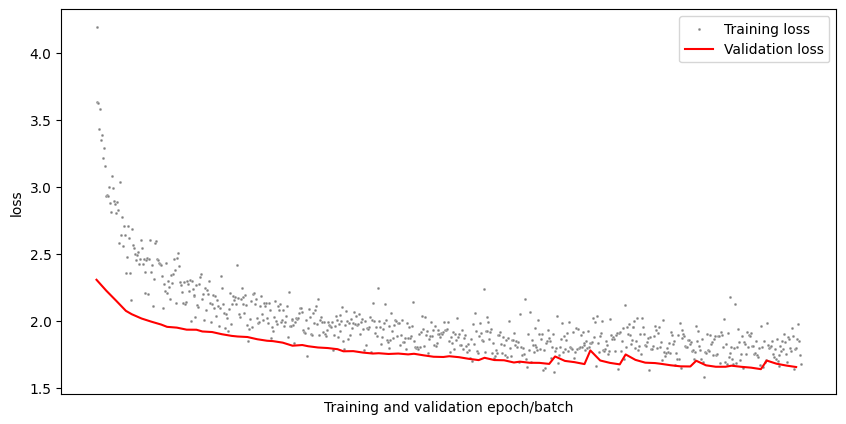

In [337]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(random_stack_training_losses_df.reset_index(), x='index', y='loss', label='Training loss', alpha=1.0, c='gray', s=4, ax=ax)
sns.lineplot(random_stack_val_losses_df.reset_index(), x='index', y='loss',  label='Validation loss', c='red', ax=ax)
plt.xticks([])
plt.xlabel('Training and validation epoch/batch')
plt.show()

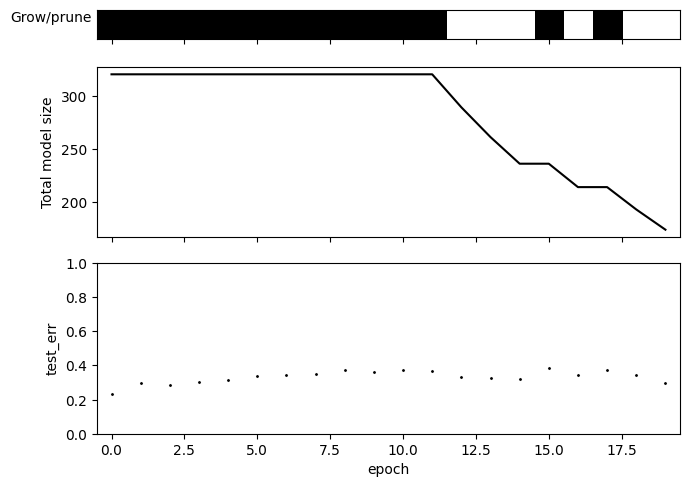

In [330]:
fig, axes = plt.subplots(3, 1, figsize=(7, 5), sharex=True, height_ratios=[1, 5, 5])
axes[0].imshow(np.array(np.array(random_model.prune_history).reshape(1, -1)), cmap='gray')
axes[0].set_yticks([])
axes[0].set_ylabel("Grow/prune", rotation=0, ha='right')

axes[1].plot(
    (np.array(random_model.conv1_kernel_count_history) + np.array(random_model.conv2_kernel_count_history)), 
    c='k'
) 
axes[1].set_ylabel("Total model size")

sns.scatterplot(random_test_df.reset_index(), x='epoch', y='test_err', ax=axes[2], c='k', s=5) 
axes[2].set_ylim(0, 1.0)
plt.tight_layout()
plt.show()


# Activity pruning

In [331]:
from src.CNN_pruning import ActivityPruneNet

In [332]:
num_classes = 10 # output number of classes
num_epochs = 20  # number of total training loops?
# batch_size = 128  # how much data to train on at a time
learning_rate = 0.005 # SGD step size. Scheduler with 0.1 for 0-100, 0.01 for 100-200, and 0.001 for 200 to 250

activity_model = ActivityPruneNet(num_training_iter=num_epochs, num_classes=num_classes, verbose=False).to(device)

activity_train_losses_epoch, activity_val_losses_epoch, activity_test_df = full_train(
    activity_model,
    train_loader, valid_loader, test_loader,
    learning_rate = 0.005,
    loss_fn = nn.CrossEntropyLoss(),
    model_update_params=True,
    plot=False,
    verbose=False,
)

Epochs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:48<00:00, 14.42s/it]

done!


In [333]:
activity_stack_training_losses_df, activity_stack_val_losses_df = format_training_outputs(activity_train_losses_epoch, activity_val_losses_epoch)

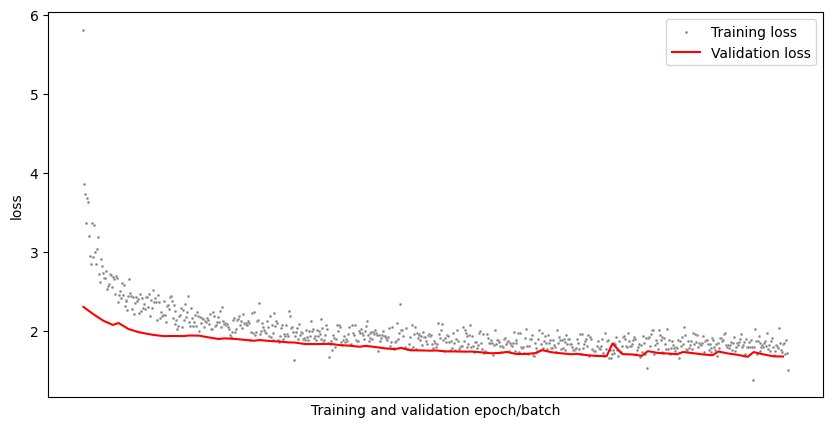

In [334]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(activity_stack_training_losses_df.reset_index(), x='index', y='loss', label='Training loss', alpha=1.0, c='gray', s=4, ax=ax)
sns.lineplot(activity_stack_val_losses_df.reset_index(), x='index', y='loss',  label='Validation loss', c='red', ax=ax)
plt.xticks([])
plt.xlabel('Training and validation epoch/batch')
plt.show()

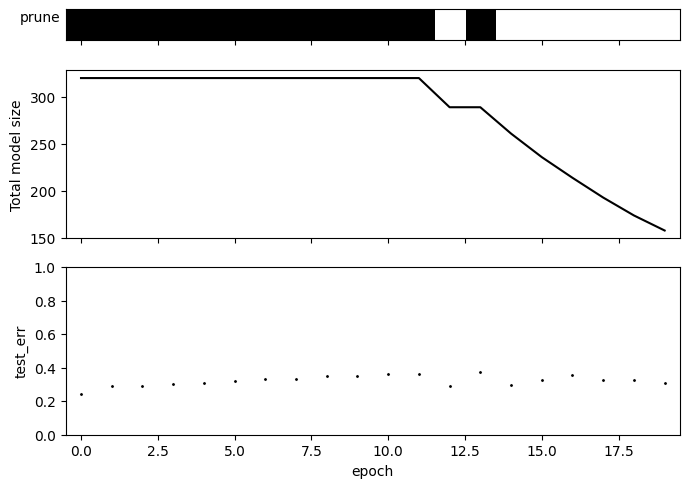

In [335]:
fig, axes = plt.subplots(3, figsize=(7, 5), sharex=True, height_ratios=[1, 5, 5])
axes[0].imshow(np.array(activity_model.prune_history).reshape(1, -1), cmap='gray')
axes[0].set_yticks([])
axes[0].set_ylabel("prune", rotation=0, ha='right')

axes[1].plot(
    (np.array(activity_model.conv1_kernel_count_history) + np.array(activity_model.conv2_kernel_count_history)), 
    c='k'
) 
axes[1].set_ylabel("Total model size")

sns.scatterplot(activity_test_df.reset_index(), x='epoch', y='test_err', ax=axes[2], c='k', s=5) 
axes[2].set_ylim(0, 1.0)
plt.tight_layout()
plt.show()


## Activity pruning with extra training epochs

In [338]:
num_classes = 10 # output number of classes
num_epochs = 20  # number of total training loops?
# batch_size = 128  # how much data to train on at a time
learning_rate = 0.005 # SGD step size. Scheduler with 0.1 for 0-100, 0.01 for 100-200, and 0.001 for 200 to 250

activity_retrain_model = ActivityPruneNet(num_training_iter=num_epochs, num_classes=num_classes, verbose=False).to(device)

In [344]:
def train_prune_with_retraining(
    model,
    train_dataloader, val_dataloader, test_dataloader,
    num_retrain_epochs=15,
    learning_rate = 1e-2, # how much to update model parameters at each epoch. Speed of learning
    loss_fn = nn.CrossEntropyLoss(),
    model_update_params=True,
    plot=False,
    verbose=True,
):
    verbose_print = print if verbose else lambda *x: None
    
    epochs = model.num_training_iter
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # make sure model is the right instance
    test_df = pd.DataFrame(index=np.arange(epochs), columns=['test_err', 'test_loss'])
    test_df.index.name = 'epoch'
    train_losses_epoch = dict()
    val_losses_epoch = dict()

    if plot: plot_model_state(model)
    for i, t in tqdm.tqdm(enumerate(range(epochs)), desc='Epochs', total=epochs):
        train_losses, val_losses = train_loop(train_dataloader, model, loss_fn, optimizer, verbose_print, val_dataloader)
        train_losses_epoch[i] = train_losses
        val_losses_epoch[i] = val_losses

        model.eval()

        if model_update_params:
            decision = model.update_params()
            if decision == 1.0:
                print("retraining")
                for i in tqdm.tqdm(range(num_retrain_epochs), total=num_retrain_epochs):
                    train_losses, val_losses = train_loop(train_dataloader, model, loss_fn, optimizer, verbose_print, val_dataloader)

        if plot: 
            verbose_print(f"Decision: {decision}")
            plot_model_state(model)
        
        test_err, test_loss = test_loop(test_dataloader, model, loss_fn, verbose_print)
        test_df.loc[i] = [test_err, test_loss]
    
    print("done!")
    return train_losses_epoch, val_losses_epoch, test_df


In [345]:
activity_retrain_train_losses_epoch, activity_retrain_val_losses_epoch, activity_retrain_test_df = train_prune_with_retraining(
    activity_retrain_model,
    train_loader, valid_loader, test_loader
)

Epochs:   0%|                                                                                                                          | 0/20 [00:00<?, ?it/s]

loss: 2.514019 [  128/50000]
Val loss: 1010.889038
loss: 2.101661 [ 1408/50000]
Val loss: 994.435516
loss: 2.333321 [ 2688/50000]
Val loss: 983.818970
loss: 2.154864 [ 3968/50000]
Val loss: 967.672318


Epochs:   5%|█████▋                                                                                                            | 1/20 [00:14<04:42, 14.86s/it]

Test Error 
 Accuracy: 29.1%, Avg loss: 1.950381

loss: 2.305603 [  128/50000]
Val loss: 964.792053
loss: 2.071610 [ 1408/50000]
Val loss: 952.145920
loss: 2.057697 [ 2688/50000]
Val loss: 946.075409
loss: 1.988728 [ 3968/50000]
Val loss: 930.235367


Epochs:  10%|███████████▍                                                                                                      | 2/20 [00:36<05:41, 19.00s/it]

Test Error 
 Accuracy: 32.8%, Avg loss: 1.906128

loss: 2.126278 [  128/50000]
Val loss: 928.444244
loss: 2.016974 [ 1408/50000]
Val loss: 916.372971
loss: 1.965512 [ 2688/50000]
Val loss: 909.296661
loss: 2.001904 [ 3968/50000]
Val loss: 902.436920


Epochs:  15%|█████████████████                                                                                                 | 3/20 [00:53<05:06, 18.05s/it]

Test Error 
 Accuracy: 34.1%, Avg loss: 1.839160

loss: 1.977178 [  128/50000]
Val loss: 891.247635
loss: 1.925719 [ 1408/50000]
Val loss: 888.647568
loss: 2.030544 [ 2688/50000]
Val loss: 886.900146
loss: 1.894548 [ 3968/50000]
Val loss: 880.505554


Epochs:  20%|██████████████████████▊                                                                                           | 4/20 [01:09<04:34, 17.15s/it]

Test Error 
 Accuracy: 35.1%, Avg loss: 1.795748

loss: 1.808810 [  128/50000]
Val loss: 872.490631
loss: 2.038520 [ 1408/50000]
Val loss: 865.612411
loss: 1.900325 [ 2688/50000]
Val loss: 859.557251
loss: 2.021493 [ 3968/50000]
Val loss: 858.383667


Epochs:  25%|████████████████████████████▌                                                                                     | 5/20 [01:24<04:05, 16.37s/it]

Test Error 
 Accuracy: 35.7%, Avg loss: 1.804979

loss: 1.658665 [  128/50000]
Val loss: 862.716705
loss: 1.952339 [ 1408/50000]
Val loss: 854.103638
loss: 1.759284 [ 2688/50000]
Val loss: 847.367279
loss: 1.889567 [ 3968/50000]
Val loss: 856.729858


Epochs:  30%|██████████████████████████████████▏                                                                               | 6/20 [01:38<03:39, 15.70s/it]

Test Error 
 Accuracy: 38.0%, Avg loss: 1.756858

loss: 1.805336 [  128/50000]
Val loss: 851.488403
loss: 1.860919 [ 1408/50000]
Val loss: 838.976715
loss: 1.888754 [ 2688/50000]
Val loss: 837.208496
loss: 1.880906 [ 3968/50000]
Val loss: 830.171432


Epochs:  35%|███████████████████████████████████████▉                                                                          | 7/20 [01:52<03:17, 15.16s/it]

Test Error 
 Accuracy: 35.3%, Avg loss: 1.753798

loss: 1.697530 [  128/50000]
Val loss: 834.121017
loss: 1.862140 [ 1408/50000]
Val loss: 832.486847
loss: 1.780234 [ 2688/50000]
Val loss: 825.001022
loss: 1.866115 [ 3968/50000]
Val loss: 818.802460


Epochs:  40%|█████████████████████████████████████████████▌                                                                    | 8/20 [02:10<03:12, 16.07s/it]

Test Error 
 Accuracy: 37.6%, Avg loss: 1.731729

loss: 1.808419 [  128/50000]
Val loss: 842.613876
loss: 1.773471 [ 1408/50000]
Val loss: 823.167526
loss: 1.835073 [ 2688/50000]
Val loss: 823.774124
loss: 1.842741 [ 3968/50000]
Val loss: 809.546631


Epochs:  45%|███████████████████████████████████████████████████▎                                                              | 9/20 [02:25<02:51, 15.58s/it]

Test Error 
 Accuracy: 37.8%, Avg loss: 1.697812

loss: 1.760131 [  128/50000]
Val loss: 819.478668
loss: 1.684323 [ 1408/50000]
Val loss: 804.458740
loss: 1.727734 [ 2688/50000]
Val loss: 808.348495
loss: 1.768986 [ 3968/50000]
Val loss: 798.603333


Epochs:  50%|████████████████████████████████████████████████████████▌                                                        | 10/20 [02:40<02:33, 15.33s/it]

Test Error 
 Accuracy: 40.7%, Avg loss: 1.644869

loss: 1.751086 [  128/50000]
Val loss: 803.530487
loss: 1.591979 [ 1408/50000]
Val loss: 798.831726
loss: 1.812948 [ 2688/50000]
Val loss: 780.743103
loss: 1.703174 [ 3968/50000]
Val loss: 783.124405


Epochs:  55%|██████████████████████████████████████████████████████████████▏                                                  | 11/20 [02:54<02:15, 15.02s/it]

Test Error 
 Accuracy: 40.4%, Avg loss: 1.621887

loss: 1.672778 [  128/50000]
Val loss: 782.768204
loss: 1.690998 [ 1408/50000]
Val loss: 784.495178
loss: 1.654965 [ 2688/50000]
Val loss: 775.120056
loss: 1.589241 [ 3968/50000]
Val loss: 780.663528
retraining



  0%|                                                                                                                                  | 0/15 [00:00<?, ?it/s]

loss: 1.708324 [  128/50000]
Val loss: 802.393112
loss: 1.852112 [ 1408/50000]
Val loss: 783.067368
loss: 1.790293 [ 2688/50000]
Val loss: 784.027695
loss: 1.536765 [ 3968/50000]
Val loss: 782.117355



  7%|████████▏                                                                                                                 | 1/15 [00:08<01:55,  8.24s/it]

loss: 1.829150 [  128/50000]
Val loss: 776.534195
loss: 1.597116 [ 1408/50000]
Val loss: 770.980453
loss: 1.679719 [ 2688/50000]
Val loss: 770.018188
loss: 1.764736 [ 3968/50000]
Val loss: 776.380463



 13%|████████████████▎                                                                                                         | 2/15 [00:17<01:51,  8.55s/it]

loss: 1.654316 [  128/50000]
Val loss: 771.478043
loss: 1.706154 [ 1408/50000]
Val loss: 764.786224
loss: 1.652134 [ 2688/50000]
Val loss: 763.884354
loss: 1.733107 [ 3968/50000]
Val loss: 764.159073



 20%|████████████████████████▍                                                                                                 | 3/15 [00:25<01:41,  8.49s/it]

loss: 1.607090 [  128/50000]
Val loss: 765.917679
loss: 1.708127 [ 1408/50000]
Val loss: 756.682922
loss: 1.686713 [ 2688/50000]
Val loss: 753.921219
loss: 1.588363 [ 3968/50000]
Val loss: 759.908783



 27%|████████████████████████████████▌                                                                                         | 4/15 [00:38<01:53, 10.32s/it]

loss: 1.556914 [  128/50000]
Val loss: 761.574356
loss: 1.408133 [ 1408/50000]
Val loss: 754.072433
loss: 1.688562 [ 2688/50000]
Val loss: 756.195816
loss: 1.410023 [ 3968/50000]
Val loss: 750.809677



 33%|████████████████████████████████████████▋                                                                                 | 5/15 [00:47<01:36,  9.65s/it]

loss: 1.594425 [  128/50000]
Val loss: 762.340988
loss: 1.439031 [ 1408/50000]
Val loss: 745.719513
loss: 1.625646 [ 2688/50000]
Val loss: 743.651062
loss: 1.671118 [ 3968/50000]
Val loss: 738.136810



 40%|████████████████████████████████████████████████▊                                                                         | 6/15 [02:04<04:53, 32.57s/it]

loss: 1.585318 [  128/50000]
Val loss: 754.967987
loss: 1.476060 [ 1408/50000]
Val loss: 741.230087
loss: 1.481338 [ 2688/50000]
Val loss: 738.571182
loss: 1.680780 [ 3968/50000]
Val loss: 742.143814



 47%|████████████████████████████████████████████████████████▍                                                                | 7/15 [06:16<13:56, 104.52s/it]

loss: 1.637630 [  128/50000]
Val loss: 744.035675
loss: 1.532619 [ 1408/50000]
Val loss: 730.338318
loss: 1.513959 [ 2688/50000]
Val loss: 728.509537
loss: 1.560876 [ 3968/50000]
Val loss: 734.290298



 53%|█████████████████████████████████████████████████████████████████                                                         | 8/15 [06:46<09:24, 80.65s/it]

loss: 1.519305 [  128/50000]
Val loss: 733.256531
loss: 1.592802 [ 1408/50000]
Val loss: 742.664093
loss: 1.668683 [ 2688/50000]
Val loss: 729.938889
loss: 1.604031 [ 3968/50000]
Val loss: 730.064987



 60%|████████████████████████████████████████████████████████████████████████▌                                                | 9/15 [10:53<13:16, 132.82s/it]

loss: 1.591485 [  128/50000]
Val loss: 723.632370
loss: 1.564934 [ 1408/50000]
Val loss: 719.113266
loss: 1.443894 [ 2688/50000]
Val loss: 732.245834
loss: 1.400816 [ 3968/50000]
Val loss: 714.787949



 67%|████████████████████████████████████████████████████████████████████████████████                                        | 10/15 [17:14<17:27, 209.43s/it]

loss: 1.485938 [  128/50000]
Val loss: 732.623322
loss: 1.415956 [ 1408/50000]
Val loss: 718.481598
loss: 1.584197 [ 2688/50000]
Val loss: 715.280441
loss: 1.410681 [ 3968/50000]
Val loss: 714.411011



 73%|████████████████████████████████████████████████████████████████████████████████████████                                | 11/15 [17:34<10:05, 151.44s/it]

loss: 1.603554 [  128/50000]
Val loss: 717.296707
loss: 1.473716 [ 1408/50000]
Val loss: 715.460526
loss: 1.541930 [ 2688/50000]
Val loss: 713.546280
loss: 1.614660 [ 3968/50000]
Val loss: 706.142456



 80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 12/15 [17:44<05:24, 108.23s/it]

loss: 1.454173 [  128/50000]
Val loss: 712.206177
loss: 1.507649 [ 1408/50000]
Val loss: 715.817520
loss: 1.558188 [ 2688/50000]
Val loss: 696.687180
loss: 1.547024 [ 3968/50000]
Val loss: 707.623077



 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 13/15 [17:53<02:36, 78.13s/it]

loss: 1.448082 [  128/50000]
Val loss: 710.836334
loss: 1.324922 [ 1408/50000]
Val loss: 690.204910
loss: 1.414362 [ 2688/50000]
Val loss: 693.590668
loss: 1.506204 [ 3968/50000]
Val loss: 692.253571



 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 14/15 [18:00<00:56, 56.90s/it]

loss: 1.587531 [  128/50000]
Val loss: 704.425659
loss: 1.514725 [ 1408/50000]
Val loss: 690.366470
loss: 1.326390 [ 2688/50000]
Val loss: 701.377975
loss: 1.561234 [ 3968/50000]
Val loss: 684.831985



Epochs:  60%|███████████████████████████████████████████████████████████████████▏                                            | 12/20 [21:20<46:14, 346.77s/it]

Test Error 
 Accuracy: 46.5%, Avg loss: 1.534615

loss: 1.586278 [  128/50000]
Val loss: 712.004501
loss: 1.274607 [ 1408/50000]
Val loss: 689.186371
loss: 1.366159 [ 2688/50000]
Val loss: 697.190964
loss: 1.330689 [ 3968/50000]
Val loss: 678.906830


Epochs:  65%|████████████████████████████████████████████████████████████████████████▊                                       | 13/20 [21:35<28:43, 246.26s/it]

Test Error 
 Accuracy: 44.9%, Avg loss: 1.498304

loss: 1.458635 [  128/50000]
Val loss: 693.899994
loss: 1.376587 [ 1408/50000]
Val loss: 676.242767
loss: 1.440979 [ 2688/50000]
Val loss: 677.637604
loss: 1.360051 [ 3968/50000]
Val loss: 675.603073
retraining



  0%|                                                                                                                                  | 0/15 [00:00<?, ?it/s]

loss: 1.398491 [  128/50000]
Val loss: 700.921661
loss: 1.514570 [ 1408/50000]
Val loss: 697.660995
loss: 1.568860 [ 2688/50000]
Val loss: 684.642502
loss: 1.477679 [ 3968/50000]
Val loss: 713.831604



  7%|████████▏                                                                                                                 | 1/15 [00:08<02:03,  8.79s/it]

loss: 1.582378 [  128/50000]
Val loss: 714.881226
loss: 1.468592 [ 1408/50000]
Val loss: 683.467880
loss: 1.327826 [ 2688/50000]
Val loss: 674.009949
loss: 1.504000 [ 3968/50000]
Val loss: 674.330597



 13%|████████████████▎                                                                                                         | 2/15 [00:17<01:51,  8.60s/it]

loss: 1.476021 [  128/50000]
Val loss: 695.712097
loss: 1.448179 [ 1408/50000]
Val loss: 681.136520
loss: 1.424315 [ 2688/50000]
Val loss: 680.093033
loss: 1.456688 [ 3968/50000]
Val loss: 673.349060



 20%|████████████████████████▍                                                                                                 | 3/15 [00:24<01:36,  8.05s/it]

loss: 1.339527 [  128/50000]
Val loss: 694.636719
loss: 1.427915 [ 1408/50000]
Val loss: 667.107224
loss: 1.375202 [ 2688/50000]
Val loss: 664.510498
loss: 1.484502 [ 3968/50000]
Val loss: 665.505203



 27%|████████████████████████████████▌                                                                                         | 4/15 [00:32<01:28,  8.07s/it]

loss: 1.584402 [  128/50000]
Val loss: 671.074219
loss: 1.408567 [ 1408/50000]
Val loss: 664.869293
loss: 1.359276 [ 2688/50000]
Val loss: 658.156540
loss: 1.374716 [ 3968/50000]
Val loss: 662.252106



 33%|████████████████████████████████████████▋                                                                                 | 5/15 [00:40<01:21,  8.13s/it]

loss: 1.432646 [  128/50000]
Val loss: 670.742493
loss: 1.315592 [ 1408/50000]
Val loss: 666.223846
loss: 1.472841 [ 2688/50000]
Val loss: 654.607193
loss: 1.281555 [ 3968/50000]
Val loss: 671.007141



 40%|████████████████████████████████████████████████▊                                                                         | 6/15 [00:48<01:12,  8.02s/it]

loss: 1.339247 [  128/50000]
Val loss: 656.069199
loss: 1.379746 [ 1408/50000]
Val loss: 657.685333
loss: 1.619306 [ 2688/50000]
Val loss: 651.814774
loss: 1.410735 [ 3968/50000]
Val loss: 658.085007



 47%|████████████████████████████████████████████████████████▉                                                                 | 7/15 [00:56<01:03,  7.89s/it]

loss: 1.300905 [  128/50000]
Val loss: 689.301575
loss: 1.503224 [ 1408/50000]
Val loss: 650.348969
loss: 1.308381 [ 2688/50000]
Val loss: 643.811310
loss: 1.403424 [ 3968/50000]
Val loss: 652.138916



 53%|█████████████████████████████████████████████████████████████████                                                         | 8/15 [01:04<00:54,  7.80s/it]

loss: 1.384644 [  128/50000]
Val loss: 673.667435
loss: 1.386356 [ 1408/50000]
Val loss: 660.549057
loss: 1.246559 [ 2688/50000]
Val loss: 646.428406
loss: 1.212367 [ 3968/50000]
Val loss: 643.756180



 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 9/15 [01:11<00:46,  7.79s/it]

loss: 1.361281 [  128/50000]
Val loss: 687.877945
loss: 1.333270 [ 1408/50000]
Val loss: 650.568771
loss: 1.332994 [ 2688/50000]
Val loss: 656.928574
loss: 1.386936 [ 3968/50000]
Val loss: 647.103210



 67%|████████████████████████████████████████████████████████████████████████████████▋                                        | 10/15 [01:19<00:38,  7.74s/it]

loss: 1.379745 [  128/50000]
Val loss: 640.836746
loss: 1.268114 [ 1408/50000]
Val loss: 645.083801
loss: 1.189556 [ 2688/50000]
Val loss: 647.548157
loss: 1.276134 [ 3968/50000]
Val loss: 641.486282



 73%|████████████████████████████████████████████████████████████████████████████████████████▋                                | 11/15 [01:27<00:30,  7.70s/it]

loss: 1.334983 [  128/50000]
Val loss: 649.983337
loss: 1.142151 [ 1408/50000]
Val loss: 642.013290
loss: 1.311145 [ 2688/50000]
Val loss: 638.037933
loss: 1.306607 [ 3968/50000]
Val loss: 648.317352



 80%|████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 12/15 [01:34<00:23,  7.73s/it]

loss: 1.330254 [  128/50000]
Val loss: 645.421204
loss: 1.159281 [ 1408/50000]
Val loss: 628.376877
loss: 1.174593 [ 2688/50000]
Val loss: 647.348053
loss: 1.230128 [ 3968/50000]
Val loss: 624.180573



 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 13/15 [01:43<00:16,  8.05s/it]

loss: 1.264832 [  128/50000]
Val loss: 634.342331
loss: 1.126720 [ 1408/50000]
Val loss: 627.468430
loss: 1.112667 [ 2688/50000]
Val loss: 620.005630
loss: 1.229994 [ 3968/50000]
Val loss: 646.865982



 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 14/15 [01:52<00:08,  8.21s/it]

loss: 1.383788 [  128/50000]
Val loss: 651.408966
loss: 1.209817 [ 1408/50000]
Val loss: 629.594406
loss: 1.155316 [ 2688/50000]
Val loss: 620.390327
loss: 1.307957 [ 3968/50000]
Val loss: 639.822311



Epochs:  70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 14/20 [23:50<21:17, 212.87s/it]

Test Error 
 Accuracy: 51.6%, Avg loss: 1.357802

loss: 1.175949 [  128/50000]
Val loss: 639.961609
loss: 1.409163 [ 1408/50000]
Val loss: 638.095795
loss: 1.402371 [ 2688/50000]
Val loss: 624.605103
loss: 1.086473 [ 3968/50000]
Val loss: 627.071609
retraining



  0%|                                                                                                                                  | 0/15 [00:00<?, ?it/s]

loss: 1.206343 [  128/50000]
Val loss: 648.546112
loss: 1.283846 [ 1408/50000]
Val loss: 626.319382
loss: 1.308906 [ 2688/50000]
Val loss: 639.378250
loss: 1.070632 [ 3968/50000]
Val loss: 624.899048



  7%|████████▏                                                                                                                 | 1/15 [00:07<01:47,  7.71s/it]

loss: 1.474349 [  128/50000]
Val loss: 656.501511
loss: 1.149280 [ 1408/50000]
Val loss: 618.477066
loss: 1.225429 [ 2688/50000]
Val loss: 610.713516
loss: 1.286637 [ 3968/50000]
Val loss: 623.314484



 13%|████████████████▎                                                                                                         | 2/15 [00:15<01:41,  7.81s/it]

loss: 1.484499 [  128/50000]
Val loss: 638.251129
loss: 1.214845 [ 1408/50000]
Val loss: 618.240875
loss: 1.199547 [ 2688/50000]
Val loss: 614.290985
loss: 1.317721 [ 3968/50000]
Val loss: 608.130859



 20%|████████████████████████▍                                                                                                 | 3/15 [00:23<01:36,  8.04s/it]

loss: 1.182915 [  128/50000]
Val loss: 659.139313
loss: 1.194753 [ 1408/50000]
Val loss: 614.147125
loss: 1.328918 [ 2688/50000]
Val loss: 613.663727
loss: 1.248190 [ 3968/50000]
Val loss: 606.811218



 27%|████████████████████████████████▌                                                                                         | 4/15 [00:31<01:28,  8.01s/it]

loss: 1.283880 [  128/50000]
Val loss: 619.665573
loss: 1.133453 [ 1408/50000]
Val loss: 614.580750
loss: 1.416926 [ 2688/50000]
Val loss: 607.691772
loss: 1.087286 [ 3968/50000]
Val loss: 602.122894



 33%|████████████████████████████████████████▋                                                                                 | 5/15 [00:39<01:20,  8.00s/it]

loss: 1.276752 [  128/50000]
Val loss: 607.879730
loss: 1.175049 [ 1408/50000]
Val loss: 604.364822
loss: 1.183223 [ 2688/50000]
Val loss: 603.117523
loss: 1.286294 [ 3968/50000]
Val loss: 604.423325



 40%|████████████████████████████████████████████████▊                                                                         | 6/15 [00:47<01:11,  7.99s/it]

loss: 1.295407 [  128/50000]
Val loss: 635.757553
loss: 1.158730 [ 1408/50000]
Val loss: 610.218079
loss: 1.215512 [ 2688/50000]
Val loss: 634.219170
loss: 1.022662 [ 3968/50000]
Val loss: 603.133224



 47%|████████████████████████████████████████████████████████▉                                                                 | 7/15 [00:55<01:03,  8.00s/it]

loss: 1.090894 [  128/50000]
Val loss: 627.823227
loss: 1.097859 [ 1408/50000]
Val loss: 598.955345
loss: 1.275455 [ 2688/50000]
Val loss: 596.505074
loss: 1.024472 [ 3968/50000]
Val loss: 589.161591



 53%|█████████████████████████████████████████████████████████████████                                                         | 8/15 [01:04<00:56,  8.10s/it]

loss: 1.339727 [  128/50000]
Val loss: 593.148712
loss: 1.236607 [ 1408/50000]
Val loss: 618.047272
loss: 1.163996 [ 2688/50000]
Val loss: 593.201874
loss: 1.176953 [ 3968/50000]
Val loss: 600.788315



 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 9/15 [01:12<00:48,  8.08s/it]

loss: 1.175378 [  128/50000]
Val loss: 632.225189
loss: 1.154858 [ 1408/50000]
Val loss: 593.290161
loss: 1.167483 [ 2688/50000]
Val loss: 594.122681
loss: 1.117363 [ 3968/50000]
Val loss: 593.590225



 67%|████████████████████████████████████████████████████████████████████████████████▋                                        | 10/15 [01:20<00:40,  8.11s/it]

loss: 1.300417 [  128/50000]
Val loss: 610.954941
loss: 0.965873 [ 1408/50000]
Val loss: 583.853485
loss: 1.264854 [ 2688/50000]
Val loss: 610.056656
loss: 1.244514 [ 3968/50000]
Val loss: 606.831055



 73%|████████████████████████████████████████████████████████████████████████████████████████▋                                | 11/15 [01:29<00:33,  8.40s/it]

loss: 1.166388 [  128/50000]
Val loss: 582.467468
loss: 1.117755 [ 1408/50000]
Val loss: 588.255684
loss: 1.180224 [ 2688/50000]
Val loss: 586.529907
loss: 1.051382 [ 3968/50000]
Val loss: 590.643188



 80%|████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 12/15 [01:38<00:25,  8.51s/it]

loss: 1.029682 [  128/50000]
Val loss: 593.424225
loss: 0.927551 [ 1408/50000]
Val loss: 586.828812
loss: 1.218693 [ 2688/50000]
Val loss: 586.713745
loss: 1.362399 [ 3968/50000]
Val loss: 600.585129



 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 13/15 [01:47<00:17,  8.71s/it]

loss: 1.416691 [  128/50000]
Val loss: 607.840408
loss: 1.035602 [ 1408/50000]
Val loss: 588.781242
loss: 1.139465 [ 2688/50000]
Val loss: 597.960190
loss: 1.266522 [ 3968/50000]
Val loss: 580.010696



 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 14/15 [01:58<00:09,  9.42s/it]

loss: 1.342354 [  128/50000]
Val loss: 611.608978
loss: 1.122481 [ 1408/50000]
Val loss: 573.359772
loss: 1.096197 [ 2688/50000]
Val loss: 577.325256
loss: 1.177081 [ 3968/50000]
Val loss: 581.541061



Epochs:  75%|████████████████████████████████████████████████████████████████████████████████████                            | 15/20 [26:13<15:59, 191.85s/it]

Test Error 
 Accuracy: 54.2%, Avg loss: 1.278661

loss: 1.098201 [  128/50000]
Val loss: 597.777679
loss: 1.259344 [ 1408/50000]
Val loss: 572.739212
loss: 1.084159 [ 2688/50000]
Val loss: 569.772720
loss: 1.205426 [ 3968/50000]
Val loss: 617.188721
retraining



  0%|                                                                                                                                  | 0/15 [00:00<?, ?it/s]

loss: 1.284860 [  128/50000]
Val loss: 647.186569
loss: 1.212184 [ 1408/50000]
Val loss: 588.189209
loss: 1.122785 [ 2688/50000]
Val loss: 592.812836
loss: 1.108140 [ 3968/50000]
Val loss: 581.212082



  7%|███████▊                                                                                                              | 1/15 [33:45<7:52:43, 2025.99s/it]

loss: 1.272944 [  128/50000]
Val loss: 608.145599
loss: 1.124263 [ 1408/50000]
Val loss: 595.421860
loss: 1.082106 [ 2688/50000]
Val loss: 565.659607
loss: 0.933443 [ 3968/50000]
Val loss: 583.510796



 13%|███████████████▎                                                                                                   | 2/15 [2:00:50<14:06:38, 3907.57s/it]

loss: 1.108606 [  128/50000]
Val loss: 577.527115
loss: 1.099644 [ 1408/50000]
Val loss: 565.463936
loss: 0.973661 [ 2688/50000]
Val loss: 567.672882
loss: 1.053762 [ 3968/50000]
Val loss: 575.025406



 20%|███████████████████████▏                                                                                            | 3/15 [2:06:33<7:35:55, 2279.63s/it]

loss: 1.178587 [  128/50000]
Val loss: 587.209534
loss: 1.273229 [ 1408/50000]
Val loss: 583.884827
loss: 1.099452 [ 2688/50000]
Val loss: 562.974213
loss: 1.098005 [ 3968/50000]
Val loss: 568.899475



 27%|██████████████████████████████▉                                                                                     | 4/15 [3:01:50<8:13:03, 2689.41s/it]

loss: 1.340513 [  128/50000]
Val loss: 632.019485
loss: 1.072142 [ 1408/50000]
Val loss: 616.422424
loss: 1.131234 [ 2688/50000]
Val loss: 591.740372
loss: 1.158314 [ 3968/50000]
Val loss: 566.260963



 33%|██████████████████████████████████████▋                                                                             | 5/15 [3:01:58<4:47:04, 1722.47s/it]

loss: 1.404882 [  128/50000]
Val loss: 617.476685
loss: 1.105465 [ 1408/50000]
Val loss: 594.067398
loss: 0.953507 [ 2688/50000]
Val loss: 561.168793
loss: 1.018205 [ 3968/50000]
Val loss: 585.648674



 40%|██████████████████████████████████████████████▍                                                                     | 6/15 [4:02:58<5:57:11, 2381.31s/it]

loss: 1.138541 [  128/50000]
Val loss: 610.500900
loss: 0.904531 [ 1408/50000]
Val loss: 582.525574
loss: 1.159588 [ 2688/50000]
Val loss: 566.577141
loss: 1.053066 [ 3968/50000]
Val loss: 576.324234



 47%|██████████████████████████████████████████████████████▏                                                             | 7/15 [5:04:01<6:13:22, 2800.31s/it]

loss: 1.089540 [  128/50000]
Val loss: 597.671761
loss: 0.928017 [ 1408/50000]
Val loss: 592.913452
loss: 1.120813 [ 2688/50000]
Val loss: 571.432884
loss: 1.048466 [ 3968/50000]
Val loss: 577.173653



 53%|█████████████████████████████████████████████████████████████▊                                                      | 8/15 [5:04:09<3:42:58, 1911.24s/it]

loss: 1.118814 [  128/50000]
Val loss: 575.430115
loss: 1.042830 [ 1408/50000]
Val loss: 566.576431
loss: 1.142177 [ 2688/50000]
Val loss: 559.983170
loss: 0.960760 [ 3968/50000]
Val loss: 576.540085



 60%|█████████████████████████████████████████████████████████████████████▌                                              | 9/15 [5:44:59<3:27:57, 2079.59s/it]

loss: 1.143858 [  128/50000]
Val loss: 566.278275
loss: 0.987566 [ 1408/50000]
Val loss: 585.696381
loss: 0.973729 [ 2688/50000]
Val loss: 578.022842
loss: 0.962511 [ 3968/50000]
Val loss: 567.832199



 67%|████████████████████████████████████████████████████████████████████████████▋                                      | 10/15 [6:05:12<2:31:00, 1812.20s/it]

loss: 1.059644 [  128/50000]
Val loss: 568.236008
loss: 0.939564 [ 1408/50000]
Val loss: 568.413467
loss: 0.842793 [ 2688/50000]
Val loss: 576.982735
loss: 0.949072 [ 3968/50000]
Val loss: 578.060272



 73%|████████████████████████████████████████████████████████████████████████████████████▎                              | 11/15 [7:06:19<2:38:39, 2379.88s/it]

loss: 1.199740 [  128/50000]
Val loss: 568.607361
loss: 1.069713 [ 1408/50000]
Val loss: 569.237396
loss: 0.983539 [ 2688/50000]
Val loss: 559.633888
loss: 1.040117 [ 3968/50000]
Val loss: 558.727982



 80%|████████████████████████████████████████████████████████████████████████████████████████████                       | 12/15 [8:07:27<2:18:35, 2771.70s/it]

loss: 1.103608 [  128/50000]
Val loss: 651.079071
loss: 0.916498 [ 1408/50000]
Val loss: 565.237938
loss: 1.103539 [ 2688/50000]
Val loss: 550.899590
loss: 1.159247 [ 3968/50000]
Val loss: 561.095016



 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▋               | 13/15 [8:07:35<1:04:28, 1934.39s/it]

loss: 1.023396 [  128/50000]
Val loss: 579.362045
loss: 0.841320 [ 1408/50000]
Val loss: 572.034119
loss: 1.030439 [ 2688/50000]
Val loss: 573.029358
loss: 1.000380 [ 3968/50000]
Val loss: 561.400482



 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 14/15 [9:06:46<40:22, 2422.86s/it]

loss: 1.226848 [  128/50000]
Val loss: 622.884270
loss: 1.050841 [ 1408/50000]
Val loss: 560.235016
loss: 0.978416 [ 2688/50000]
Val loss: 585.048431
loss: 1.012245 [ 3968/50000]
Val loss: 587.522293



Epochs:  80%|████████████████████████████████████████████████████████████████████████████████████                     | 16/20 [9:35:05<11:09:46, 10046.65s/it]

Test Error 
 Accuracy: 52.8%, Avg loss: 1.323394

loss: 0.821796 [  128/50000]
Val loss: 571.330215
loss: 0.956247 [ 1408/50000]
Val loss: 571.495972
loss: 0.976556 [ 2688/50000]
Val loss: 610.122307
loss: 1.033006 [ 3968/50000]
Val loss: 562.516464
retraining



  0%|                                                                                                                                  | 0/15 [00:00<?, ?it/s]

loss: 0.989068 [  128/50000]
Val loss: 626.963104
loss: 0.946076 [ 1408/50000]
Val loss: 547.598778
loss: 0.995965 [ 2688/50000]
Val loss: 556.162354
loss: 1.062989 [ 3968/50000]
Val loss: 589.339493



  7%|███████▋                                                                                                           | 1/15 [1:01:06<14:15:34, 3666.78s/it]

loss: 1.030719 [  128/50000]
Val loss: 574.061874
loss: 0.965594 [ 1408/50000]
Val loss: 548.581253
loss: 1.043287 [ 2688/50000]
Val loss: 587.664505
loss: 0.810753 [ 3968/50000]
Val loss: 576.556068



 13%|███████████████▎                                                                                                   | 2/15 [1:51:21<11:51:19, 3283.05s/it]

loss: 1.169942 [  128/50000]
Val loss: 622.680054
loss: 1.073871 [ 1408/50000]
Val loss: 557.375313
loss: 0.890314 [ 2688/50000]
Val loss: 552.746513
loss: 0.893517 [ 3968/50000]
Val loss: 553.761787



 20%|███████████████████████▏                                                                                            | 3/15 [1:51:28<5:57:27, 1787.29s/it]

loss: 1.285569 [  128/50000]
Val loss: 642.583237
loss: 0.992086 [ 1408/50000]
Val loss: 548.181122
loss: 0.871251 [ 2688/50000]
Val loss: 562.066345
loss: 0.929644 [ 3968/50000]
Val loss: 597.681511



 27%|██████████████████████████████▋                                                                                    | 4/15 [3:48:20<11:45:47, 3849.80s/it]

loss: 1.052348 [  128/50000]
Val loss: 558.898872
loss: 1.020519 [ 1408/50000]
Val loss: 615.076691
loss: 1.023651 [ 2688/50000]
Val loss: 559.814621
loss: 0.993936 [ 3968/50000]
Val loss: 559.396332



 33%|██████████████████████████████████████▎                                                                            | 5/15 [8:47:28<24:48:58, 8933.89s/it]

loss: 1.027144 [  128/50000]
Val loss: 599.300842
loss: 0.953063 [ 1408/50000]
Val loss: 565.505737
loss: 0.960795 [ 2688/50000]
Val loss: 596.183365
loss: 1.052438 [ 3968/50000]
Val loss: 543.187912



 40%|█████████████████████████████████████████████▌                                                                    | 6/15 [10:48:33<20:54:58, 8366.46s/it]

loss: 0.971605 [  128/50000]
Val loss: 558.877151
loss: 1.000149 [ 1408/50000]
Val loss: 602.676315
loss: 1.170235 [ 2688/50000]
Val loss: 569.738922
loss: 1.059101 [ 3968/50000]
Val loss: 588.060257



 47%|█████████████████████████████████████████████████████▏                                                            | 7/15 [10:48:41<12:31:09, 5633.75s/it]

loss: 1.171641 [  128/50000]
Val loss: 659.079926
loss: 1.007743 [ 1408/50000]
Val loss: 580.290779
loss: 1.041011 [ 2688/50000]
Val loss: 565.098129
loss: 0.839931 [ 3968/50000]
Val loss: 568.929123



 53%|█████████████████████████████████████████████████████████████▎                                                     | 8/15 [11:49:47<9:44:10, 5007.24s/it]

loss: 0.996373 [  128/50000]
Val loss: 586.973419
loss: 0.910810 [ 1408/50000]
Val loss: 561.217102
loss: 0.886910 [ 2688/50000]
Val loss: 563.767883
loss: 0.916741 [ 3968/50000]
Val loss: 567.238144



 60%|█████████████████████████████████████████████████████████████████████                                              | 9/15 [11:49:54<5:44:24, 3444.12s/it]

loss: 1.081799 [  128/50000]
Val loss: 562.322845
loss: 0.855639 [ 1408/50000]
Val loss: 588.301895
loss: 0.978986 [ 2688/50000]
Val loss: 564.895325
loss: 0.817965 [ 3968/50000]
Val loss: 576.805405



 67%|████████████████████████████████████████████████████████████████████████████                                      | 10/15 [12:01:23<3:36:07, 2593.57s/it]

loss: 0.972324 [  128/50000]
Val loss: 632.383743
loss: 0.960837 [ 1408/50000]
Val loss: 551.925972
loss: 0.878362 [ 2688/50000]
Val loss: 561.669312
loss: 0.892643 [ 3968/50000]
Val loss: 564.008423



 73%|███████████████████████████████████████████████████████████████████████████████████▌                              | 11/15 [12:50:25<3:00:00, 2700.16s/it]

loss: 1.047043 [  128/50000]
Val loss: 576.584305
loss: 0.839445 [ 1408/50000]
Val loss: 558.189407
loss: 1.004518 [ 2688/50000]
Val loss: 553.240616
loss: 0.840549 [ 3968/50000]
Val loss: 555.847878



 80%|███████████████████████████████████████████████████████████████████████████████████████████▏                      | 12/15 [13:50:30<2:28:46, 2975.43s/it]

loss: 0.897179 [  128/50000]
Val loss: 571.577118
loss: 0.926843 [ 1408/50000]
Val loss: 566.576752
loss: 0.972077 [ 2688/50000]
Val loss: 582.834969
loss: 0.986511 [ 3968/50000]
Val loss: 568.830170



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▊               | 13/15 [13:50:39<1:09:13, 2076.99s/it]

loss: 0.936431 [  128/50000]
Val loss: 587.241730
loss: 0.744731 [ 1408/50000]
Val loss: 543.042824
loss: 0.869596 [ 2688/50000]
Val loss: 549.734634
loss: 0.763706 [ 3968/50000]
Val loss: 581.811790



 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 14/15 [13:50:49<24:12, 1452.54s/it]

loss: 0.992619 [  128/50000]
Val loss: 585.932045
loss: 0.872937 [ 1408/50000]
Val loss: 553.673889
loss: 0.838227 [ 2688/50000]
Val loss: 549.296814
loss: 0.795815 [ 3968/50000]
Val loss: 550.606483



Epochs:  85%|████████████████████████████████████████████████████████████████████████████████████████▍               | 17/20 [24:47:18<19:34:11, 23483.77s/it]

Test Error 
 Accuracy: 57.8%, Avg loss: 1.219990

loss: 1.023071 [  128/50000]
Val loss: 613.361145
loss: 1.059736 [ 1408/50000]
Val loss: 560.388184
loss: 0.840689 [ 2688/50000]
Val loss: 564.056129
loss: 0.802039 [ 3968/50000]
Val loss: 567.120720
retraining



  0%|                                                                                                                                  | 0/15 [00:00<?, ?it/s]

loss: 1.223275 [  128/50000]
Val loss: 618.801407
loss: 0.973401 [ 1408/50000]
Val loss: 547.691139
loss: 0.878406 [ 2688/50000]
Val loss: 551.604446
loss: 0.803640 [ 3968/50000]
Val loss: 554.544914



  7%|████████▏                                                                                                                 | 1/15 [00:08<01:54,  8.15s/it]

loss: 0.869843 [  128/50000]
Val loss: 578.553589
loss: 0.821387 [ 1408/50000]
Val loss: 557.407616
loss: 0.948797 [ 2688/50000]
Val loss: 541.289139
loss: 0.956503 [ 3968/50000]
Val loss: 579.143272



 13%|███████████████▍                                                                                                    | 2/15 [1:01:12<7:47:41, 2158.60s/it]

loss: 0.924857 [  128/50000]
Val loss: 587.844360
loss: 0.872318 [ 1408/50000]
Val loss: 553.722145
loss: 0.869140 [ 2688/50000]
Val loss: 571.320740
loss: 0.925033 [ 3968/50000]
Val loss: 552.308533



 20%|███████████████████████▏                                                                                            | 3/15 [1:01:20<3:55:20, 1176.68s/it]

loss: 1.055796 [  128/50000]
Val loss: 564.632751
loss: 0.866916 [ 1408/50000]
Val loss: 547.280396
loss: 0.901179 [ 2688/50000]
Val loss: 594.265625
loss: 0.946945 [ 3968/50000]
Val loss: 584.538406



 27%|███████████████████████████████▏                                                                                     | 4/15 [1:01:28<2:11:08, 715.33s/it]

loss: 1.333932 [  128/50000]
Val loss: 610.251251
loss: 0.844663 [ 1408/50000]
Val loss: 546.991402
loss: 0.906150 [ 2688/50000]
Val loss: 554.674026
loss: 0.885445 [ 3968/50000]
Val loss: 714.582275



 33%|███████████████████████████████████████                                                                              | 5/15 [1:05:11<1:29:37, 537.77s/it]

loss: 0.908234 [  128/50000]
Val loss: 582.311371
loss: 0.893727 [ 1408/50000]
Val loss: 550.008736
loss: 0.848702 [ 2688/50000]
Val loss: 539.825577
loss: 0.799659 [ 3968/50000]
Val loss: 557.639511



 40%|██████████████████████████████████████████████▍                                                                     | 6/15 [2:02:20<3:48:06, 1520.76s/it]

loss: 0.807361 [  128/50000]
Val loss: 595.559959
loss: 0.892516 [ 1408/50000]
Val loss: 542.109741
loss: 0.777500 [ 2688/50000]
Val loss: 548.615753
loss: 0.815731 [ 3968/50000]
Val loss: 588.271179



 47%|██████████████████████████████████████████████████████▏                                                             | 7/15 [2:45:28<4:09:17, 1869.72s/it]

loss: 0.743551 [  128/50000]
Val loss: 599.026367
loss: 0.903326 [ 1408/50000]
Val loss: 580.911362
loss: 0.770908 [ 2688/50000]
Val loss: 557.302055
loss: 0.669412 [ 3968/50000]
Val loss: 550.329697



 53%|█████████████████████████████████████████████████████████████▊                                                      | 8/15 [2:45:37<2:29:01, 1277.40s/it]

loss: 1.016132 [  128/50000]
Val loss: 606.161957
loss: 0.926124 [ 1408/50000]
Val loss: 563.797501
loss: 0.843079 [ 2688/50000]
Val loss: 635.053604
loss: 0.833213 [ 3968/50000]
Val loss: 542.673615



 60%|██████████████████████████████████████████████████████████████████████▏                                              | 9/15 [2:45:45<1:28:03, 880.58s/it]

loss: 0.987750 [  128/50000]
Val loss: 596.450974
loss: 0.785663 [ 1408/50000]
Val loss: 546.017586
loss: 0.853677 [ 2688/50000]
Val loss: 553.158646
loss: 0.818352 [ 3968/50000]
Val loss: 550.022751



 67%|█████████████████████████████████████████████████████████████████████████████▎                                      | 10/15 [3:03:27<1:18:03, 936.66s/it]

loss: 0.914994 [  128/50000]
Val loss: 575.586227
loss: 0.801939 [ 1408/50000]
Val loss: 565.045975
loss: 0.838032 [ 2688/50000]
Val loss: 540.532486
loss: 0.889905 [ 3968/50000]
Val loss: 553.672340



 73%|██████████████████████████████████████████████████████████████████████████████████████▌                               | 11/15 [3:03:35<43:29, 652.32s/it]

loss: 1.338557 [  128/50000]
Val loss: 737.271484
loss: 0.707817 [ 1408/50000]
Val loss: 588.128494
loss: 0.877882 [ 2688/50000]
Val loss: 586.923904
loss: 0.713278 [ 3968/50000]
Val loss: 593.019318



 80%|████████████████████████████████████████████████████████████████████████████████████████████                       | 12/15 [4:04:40<1:18:26, 1568.91s/it]

loss: 1.039765 [  128/50000]
Val loss: 633.419479
loss: 0.855815 [ 1408/50000]
Val loss: 539.930420
loss: 0.967393 [ 2688/50000]
Val loss: 546.947662
loss: 0.841473 [ 3968/50000]
Val loss: 544.507248



 87%|█████████████████████████████████████████████████████████████████████████████████████████████████               | 13/15 [21:24:35<11:06:30, 19995.23s/it]

loss: 0.977494 [  128/50000]
Val loss: 599.045647
loss: 0.809511 [ 1408/50000]
Val loss: 619.630669
loss: 0.867814 [ 2688/50000]
Val loss: 549.360321
loss: 0.792239 [ 3968/50000]
Val loss: 563.425980



 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 14/15 [21:25:03<3:52:43, 13964.00s/it]

loss: 0.758362 [  128/50000]
Val loss: 543.655846
loss: 0.831297 [ 1408/50000]
Val loss: 559.772186
loss: 0.815678 [ 2688/50000]
Val loss: 535.033073
loss: 0.794665 [ 3968/50000]
Val loss: 546.901260



Epochs:  90%|█████████████████████████████████████████████████████████████████████████████████████████████▌          | 18/20 [46:53:40<22:24:41, 40340.62s/it]

Test Error 
 Accuracy: 60.5%, Avg loss: 1.133462

loss: 0.780514 [  128/50000]
Val loss: 558.999962
loss: 0.726844 [ 1408/50000]
Val loss: 523.051636
loss: 0.815822 [ 2688/50000]
Val loss: 568.802704
loss: 0.751917 [ 3968/50000]
Val loss: 551.024818
retraining



  0%|                                                                                                                                  | 0/15 [00:00<?, ?it/s]

loss: 1.050181 [  128/50000]
Val loss: 572.849365
loss: 0.865681 [ 1408/50000]
Val loss: 643.159149
loss: 0.830993 [ 2688/50000]
Val loss: 572.597931
loss: 0.750982 [ 3968/50000]
Val loss: 568.137520



  7%|███████▉                                                                                                               | 1/15 [15:34<3:37:56, 934.06s/it]

loss: 0.995225 [  128/50000]
Val loss: 599.219543
loss: 0.843515 [ 1408/50000]
Val loss: 579.041870
loss: 0.842708 [ 2688/50000]
Val loss: 553.659218
loss: 0.917151 [ 3968/50000]
Val loss: 566.980927



 13%|███████████████▊                                                                                                       | 2/15 [15:48<1:25:08, 392.99s/it]

loss: 0.979143 [  128/50000]
Val loss: 573.328041
loss: 0.988926 [ 1408/50000]
Val loss: 558.180084
loss: 0.837290 [ 2688/50000]
Val loss: 583.298515
loss: 0.911966 [ 3968/50000]
Val loss: 567.818588



 20%|███████████████████████▊                                                                                               | 3/15 [31:54<2:10:57, 654.76s/it]

loss: 0.983172 [  128/50000]
Val loss: 599.905739
loss: 0.849090 [ 1408/50000]
Val loss: 537.362503
loss: 0.801552 [ 2688/50000]
Val loss: 603.850723
loss: 0.797602 [ 3968/50000]
Val loss: 548.935905



 27%|███████████████████████████████▋                                                                                       | 4/15 [32:15<1:14:08, 404.39s/it]

loss: 1.020659 [  128/50000]
Val loss: 552.455276
loss: 0.653561 [ 1408/50000]
Val loss: 579.275772
loss: 0.694053 [ 2688/50000]
Val loss: 575.459351
loss: 0.765249 [ 3968/50000]
Val loss: 583.259125



 33%|███████████████████████████████████████▋                                                                               | 5/15 [48:37<1:42:07, 612.76s/it]

loss: 1.014105 [  128/50000]
Val loss: 632.396202
loss: 0.916679 [ 1408/50000]
Val loss: 549.637642
loss: 0.886899 [ 2688/50000]
Val loss: 569.431686
loss: 0.764931 [ 3968/50000]
Val loss: 606.308029



 40%|███████████████████████████████████████████████▌                                                                       | 6/15 [49:08<1:02:15, 415.04s/it]

loss: 1.129608 [  128/50000]
Val loss: 617.586731
loss: 0.889525 [ 1408/50000]
Val loss: 571.315475
loss: 0.733252 [ 2688/50000]
Val loss: 552.086792
loss: 0.750972 [ 3968/50000]
Val loss: 567.462143



 47%|██████████████████████████████████████████████████████▌                                                              | 7/15 [1:04:55<1:18:30, 588.82s/it]

loss: 1.284848 [  128/50000]
Val loss: 600.775284
loss: 0.771857 [ 1408/50000]
Val loss: 576.576668
loss: 0.781970 [ 2688/50000]
Val loss: 552.127655
loss: 0.743256 [ 3968/50000]
Val loss: 552.521545



 53%|███████████████████████████████████████████████████████████████▍                                                       | 8/15 [1:05:17<47:38, 408.37s/it]

loss: 0.884860 [  128/50000]
Val loss: 557.334534
loss: 0.834555 [ 1408/50000]
Val loss: 543.127563
loss: 0.719191 [ 2688/50000]
Val loss: 560.670494
loss: 0.818043 [ 3968/50000]
Val loss: 547.375153



 60%|███████████████████████████████████████████████████████████████████████▍                                               | 9/15 [1:21:09<57:50, 578.39s/it]

loss: 0.883465 [  128/50000]
Val loss: 641.143234
loss: 0.811821 [ 1408/50000]
Val loss: 567.582413
loss: 0.686876 [ 2688/50000]
Val loss: 562.576965
loss: 0.764993 [ 3968/50000]
Val loss: 573.081963



 67%|██████████████████████████████████████████████████████████████████████████████▋                                       | 10/15 [1:21:28<33:49, 405.85s/it]

loss: 0.883781 [  128/50000]
Val loss: 651.043304
loss: 0.923433 [ 1408/50000]
Val loss: 562.223358
loss: 0.777035 [ 2688/50000]
Val loss: 542.982437
loss: 0.705637 [ 3968/50000]
Val loss: 600.270782



 73%|██████████████████████████████████████████████████████████████████████████████████████▌                               | 11/15 [1:32:36<32:24, 486.07s/it]

loss: 1.254294 [  128/50000]
Val loss: 603.830704
loss: 0.700487 [ 1408/50000]
Val loss: 565.860672
loss: 0.685223 [ 2688/50000]
Val loss: 586.541031
loss: 0.819257 [ 3968/50000]
Val loss: 551.674614



 80%|██████████████████████████████████████████████████████████████████████████████████████████████▍                       | 12/15 [2:00:52<42:41, 853.89s/it]

loss: 0.895318 [  128/50000]
Val loss: 637.075043
loss: 0.843831 [ 1408/50000]
Val loss: 552.535446
loss: 0.619901 [ 2688/50000]
Val loss: 610.541367
loss: 0.755906 [ 3968/50000]
Val loss: 586.594711



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 13/15 [2:16:50<29:30, 885.45s/it]

loss: 0.866046 [  128/50000]
Val loss: 651.003036
loss: 0.765889 [ 1408/50000]
Val loss: 572.939278
loss: 0.819868 [ 2688/50000]
Val loss: 593.329697
loss: 0.689153 [ 3968/50000]
Val loss: 545.012848



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 14/15 [2:17:04<10:22, 622.42s/it]

loss: 0.694009 [  128/50000]
Val loss: 589.267014
loss: 0.783175 [ 1408/50000]
Val loss: 531.843178
loss: 0.693888 [ 2688/50000]
Val loss: 576.218895
loss: 0.731932 [ 3968/50000]
Val loss: 566.636955



Epochs:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████▊     | 19/20 [50:32:59<8:56:16, 32176.82s/it]

Test Error 
 Accuracy: 55.7%, Avg loss: 1.343938

loss: 0.889805 [  128/50000]
Val loss: 598.237068
loss: 0.579703 [ 1408/50000]
Val loss: 559.283829
loss: 0.627914 [ 2688/50000]
Val loss: 553.259224
loss: 0.717078 [ 3968/50000]
Val loss: 543.258606
retraining



  0%|                                                                                                                                  | 0/15 [00:00<?, ?it/s]

loss: 0.820520 [  128/50000]
Val loss: 623.987923
loss: 0.921672 [ 1408/50000]
Val loss: 578.800140
loss: 0.674497 [ 2688/50000]
Val loss: 544.098686
loss: 0.765369 [ 3968/50000]
Val loss: 552.413132



  7%|████████                                                                                                                 | 1/15 [04:09<58:06, 249.06s/it]

loss: 0.805180 [  128/50000]
Val loss: 730.562057
loss: 0.711612 [ 1408/50000]
Val loss: 555.142288
loss: 0.834089 [ 2688/50000]
Val loss: 574.692543
loss: 0.677203 [ 3968/50000]
Val loss: 540.986626



 13%|████████████████▏                                                                                                        | 2/15 [04:24<24:12, 111.72s/it]

loss: 1.103376 [  128/50000]
Val loss: 611.059402
loss: 0.922646 [ 1408/50000]
Val loss: 575.758820
loss: 0.627770 [ 2688/50000]
Val loss: 656.208115
loss: 0.604712 [ 3968/50000]
Val loss: 614.810608



 20%|███████████████████████▌                                                                                              | 3/15 [52:05<4:33:24, 1367.05s/it]

loss: 0.735029 [  128/50000]
Val loss: 585.754677
loss: 0.665299 [ 1408/50000]
Val loss: 602.364929
loss: 0.738236 [ 2688/50000]
Val loss: 533.787926
loss: 0.854498 [ 3968/50000]
Val loss: 539.087486



 27%|██████████████████████████████▉                                                                                     | 4/15 [1:45:22<6:23:03, 2089.41s/it]

loss: 0.925693 [  128/50000]
Val loss: 619.252045
loss: 0.700587 [ 1408/50000]
Val loss: 580.036743
loss: 0.772376 [ 2688/50000]
Val loss: 574.268074
loss: 0.772626 [ 3968/50000]
Val loss: 564.978867



 33%|██████████████████████████████████████▋                                                                             | 5/15 [1:52:14<4:07:24, 1484.45s/it]

loss: 0.715064 [  128/50000]
Val loss: 555.966393
loss: 0.814201 [ 1408/50000]
Val loss: 563.439758
loss: 0.721410 [ 2688/50000]
Val loss: 558.839111
loss: 0.747985 [ 3968/50000]
Val loss: 757.177582
loss: 0.751904 [  128/50000]
Val loss: 680.796860
loss: 0.816900 [ 1408/50000]
Val loss: 547.351700
loss: 0.681337 [ 2688/50000]
Val loss: 573.195862
loss: 0.677481 [ 3968/50000]
Val loss: 554.012756
loss: 0.744970 [  128/50000]
Val loss: 590.610474
loss: 0.609142 [ 1408/50000]
Val loss: 570.379372
loss: 0.737088 [ 2688/50000]
Val loss: 523.319809
loss: 0.570820 [ 3968/50000]
Val loss: 545.899223
loss: 0.841228 [  128/50000]
Val loss: 597.350876
loss: 0.707233 [ 1408/50000]
Val loss: 585.542328
loss: 0.760048 [ 2688/50000]
Val loss: 558.171417
loss: 0.644265 [ 3968/50000]
Val loss: 553.842415
loss: 1.015154 [  128/50000]
Val loss: 811.722351
loss: 0.719690 [ 1408/50000]
Val loss: 556.189278
loss: 0.806596 [ 2688/50000]
Val loss: 582.326744
loss: 0.839643 [ 3968/50000]
Val loss: 574.867401


Epochs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [52:03:27<00:00, 9370.40s/it]

Test Error 
 Accuracy: 52.8%, Avg loss: 1.503831

done!
